In [1]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from noise_utils import AddNoise, RemoveReadoutErrors

plt.style.use({'figure.facecolor':'white'})
D = {'output': 'mpl', 'fold': -1}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend_ideal = QasmSimulator() # Noiseless
real_backend = provider.get_backend('ibm_algiers')
estimator_ideal = Estimator()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_real_backend = {'shots': 10000, 'backend': real_backend, 'name': 'real_backend'}

In [3]:
from qiskit import *
from typing import TypedDict

import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value, Counts
from typing import Union, List, Dict

class CountsProcess:

    @classmethod
    def pauli_exp_val_all1Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                # In the string representation qubit-0 corresponds to the right-most Pauli character
                pauli = SparsePauliOp.from_sparse_list([("Z", [n], 1)], nq)
                expect = sampled_expectation_value(counts, pauli)
                if nolabels:
                    expects += [expect]
                else:
                    expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all1Q_for_counts(count)
                expects += [expect]
            return expects

    @classmethod
    def pauli_exp_val_all2Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                for m in range(n+1, nq):
                    # In the string representation qubit-0 corresponds to the right-most Pauli character
                    pauli = SparsePauliOp.from_sparse_list([("ZZ", [n,m], 1)], nq)
                    expect = sampled_expectation_value(counts, pauli)
                    if nolabels:
                        expects += [expect]
                    else:
                        expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all2Q_for_counts(count)
                expects += [expect]
            return expects

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, sweep_steps = None, measure_bases = None):
        sweep_steps = sweep_steps or [16]
        measure_bases = measure_bases or ['Z']

        circs = []
        run_params = []
        for basis in measure_bases:
            for depth in range(*sweep_steps):
                ops['measure_basis'] = basis
                ops['depth'] = depth
                qc = cls.make_quantum_circuit(ops)
                qc.metadata = {}
                qc.metadata['measure_basis'] = basis
                qc.metadata['depth'] = depth
                run_params += [qc.metadata.copy()]
                circs += [qc]
        return circs, run_params

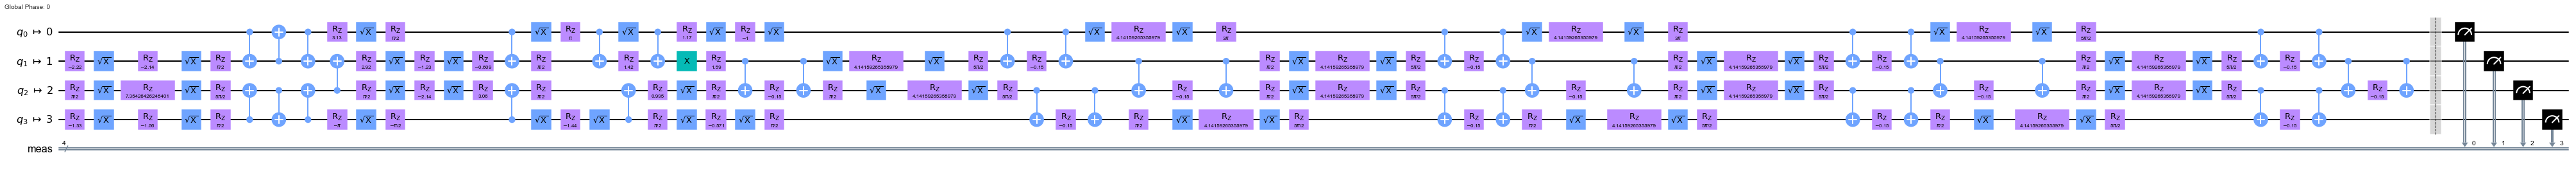

In [16]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def construct_ising_circuit_random_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    qc_init.barrier()
    max_step = 10
    qc_list = []
    for i in range(max_step):
        qc_list.append(qc_init.compose(cls.make_circs_sweep(ops, sweep_steps=[max_step], measure_bases=['Z'])[0][i], list(range(4))))
    return qc_list

from qiskit.transpiler.passes import RemoveBarriers
np.random.seed(5)
J = 0.15
basis = 'Z'
random_ising = construct_ising_circuit_random_init(J, basis, 2)
random_ising = [RemoveBarriers()(x) for x in random_ising]
######################## NEED TO CHANGE THE BACKEND HERE for OLS Full to work #############################
qc_list = transpile(random_ising, backend=real_backend, optimization_level=3, initial_layout=[0, 1, 2, 3])
qc_list[5].draw('mpl', fold=-1, idle_wires=False)
###########################################################################################################

In [17]:
len(qc_list)

10

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import Estimator as RuntimeEstimator

service = QiskitRuntimeService()
options = Options()
options.resilience_level = 2
options.optimization_level = 1
options.execution.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'

runtime_estimator = RuntimeEstimator(session=Session(service=service, backend=real_backend.name), options=options)

In [19]:
obs_list = ['ZIII', 'IZII', 'IIZI', 'IIIZ']

def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [21]:
padded_obs_all_circs = []
for trans_circuit in qc_list:
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 4), 27)) for obs in obs_list]

circs_to_submit = []
for circ in qc_list:
    circ.remove_final_measurements()
    circs_to_submit.extend([circ]*len(obs_list))

job = runtime_estimator.run(
    circuits=circs_to_submit,
    observables=padded_obs_all_circs
)
print(job.job_id())

to_save = {
    'job_id': job.job_id(),
    'shots': 10000,
    'backend': real_backend.name,
}
root = '/Users/haoranliao/GitHub/blackwater/docs/tutorials/data/ising_init_from_qasm_hardware'
with open(root+f'/single_J0_15.json', 'w') as file:
    json.dump(to_save, file)

ciiaabk60l54kvc6b3og


In [12]:
from tqdm.notebook import tqdm

fix_random_seed(0)

num_traj = 1

def run_ising_steps(be, r_c_n):
    exp_Z_all_ideal = []
    exp_Z_all_noisy = []
    exp_Z_all_mitigated_dict = defaultdict(list)

    for _ in range(num_traj):

        transpiled_qc_list = transpile(qc_list, be, optimization_level=3)
        job_ideal = execute(qc_list, **run_config_ideal)
        job_noisy = execute(transpiled_qc_list, **r_c_n)

        exp_Z_ideal = []
        exp_Z_noisy = []
        exp_Z_mitigated_dict = defaultdict(list)

        for i in tqdm(range(len(qc_list))):
            counts_ideal = job_ideal.result().get_counts()[i]
            counts_noisy = job_noisy.result().get_counts()[i]

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            exp_Z_ideal.append(list(ideal_exp_val))  # Single-Z expectation value of each qubit
            exp_Z_noisy.append(list(noisy_exp_val))  # Single-Z expectation value of each qubit

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled_qc_list[i],
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=transpiled_qc_list[i].depth()
            ).to_pyg_data()

            X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

            for j, (model, mtype) in enumerate(models):
                if mtype == 'mlp':
                    mitigated_exp_val = model(X).tolist()[0]
                elif mtype == 'gnn':
                    mitigated_exp_val = model(entry.noisy_0,
                                            entry.observable,
                                            entry.circuit_depth,
                                            entry.x,
                                            entry.edge_index,
                                            entry.batch).tolist()[0]
                elif mtype in ['ols_full', 'rfr_full']:
                    mitigated_exp_val = model.predict(X).tolist()[0]
                elif mtype in ['ols', 'rfr']:
                    mitigated_exp_val = model.predict(X[:, -4:]).tolist()[0]
                elif mtype in ['rfr_list']:
                    mitigated_exp_val = []
                    for q, m in enumerate(model):
                        mitigated_exp_val.append(m.predict(X))
                    mitigated_exp_val = np.array(mitigated_exp_val).transpose()
                elif mtype in ['zne']:
                    mitigated_exp_val = zne_mitigating_single_z(transpiled_qc_list[i], be, PolynomialExtrapolator(degree=1))
                else:
                    raise NotImplementedError

                exp_Z_mitigated_dict[j].append(mitigated_exp_val)

        exp_Z_all_ideal.append(exp_Z_ideal)
        exp_Z_all_noisy.append(exp_Z_noisy)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            exp_Z_all_mitigated_dict[k].append(exp_Z_mitigated)

    return exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict

######################## Need to change ##############################
exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict = run_ising_steps(backend_noisy_no_readout, run_config_noisy_no_readout)
######################## Need to change ##############################

random seed fixed to 0


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/haoranliao/Desktop/prototype-zne-main/zne/extrapolation/polynomial_extrapolator.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - RSS / TSS
/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/haoranliao/Desktop/prototype-zne-main/zne/extrapolation/polynomial_extrapolator.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - RSS / TSS
/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/haoranliao/Desktop/prototype-zne-main/zne/extrapolation/polynomial_extrapolator.py:149: RuntimeWarning: divide by zero encountered 

In [13]:
exp_Z_all_ideal = np.array(exp_Z_all_ideal).squeeze()
exp_Z_all_noisy = np.array(exp_Z_all_noisy).squeeze()
for key, val in exp_Z_all_mitigated_dict.items():
    exp_Z_all_mitigated_dict[key] = np.array(val).squeeze()

In [14]:
k = 0
print(exp_Z_all_ideal[k])
print(exp_Z_all_noisy[k])
print(exp_Z_all_mitigated_dict[4][k])

[ 0.1308  0.4886 -1.     -0.2822]
[ 0.1376  0.4752 -1.     -0.2924]
[ 0.1396  0.4954 -0.     -0.2588]


In [158]:
exp_Z_all_mitigated_dict[4][0][2] = -1
exp_Z_all_mitigated_dict[4][0]

array([ 0.0954,  0.4928, -1.    , -0.256 ])

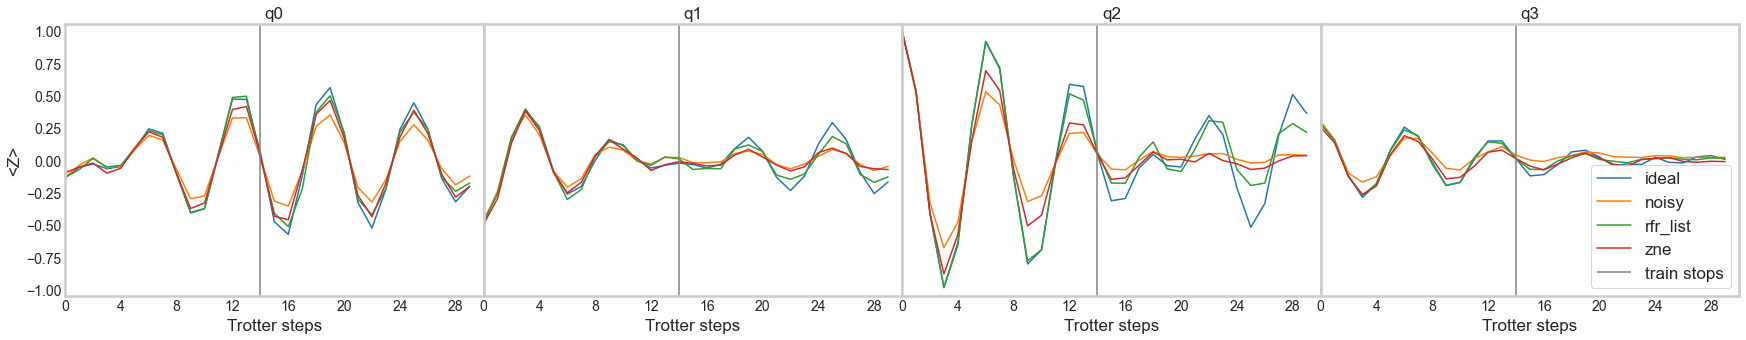

In [159]:
import matplotlib as mpl
ms, fs, lw, elw, cs = 9, 17, 2.5, 2, 0
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', weight='normal')

fig = plt.figure(figsize=(30, 5))
ax = [fig.add_subplot(1,4,i+1) for i in range(4)]
plt.style.use({'figure.facecolor':'white'})

for q in range(4):
    ax[q].plot(-exp_Z_all_ideal[:, q], label='ideal')
    ax[q].plot(-exp_Z_all_noisy[:, q], label='noisy')
    for key, val in exp_Z_all_mitigated_dict.items():
        if models[key][1] in [
            # 'gnn',
            # 'mlp',
            # 'ols_full',
            'rfr_list',
            'zne'
        ]:
            ax[q].plot(-val[:, q], label=f'{models[key][1]}')
    ax[q].vlines(x=14, ymin=-2, ymax=2, color='gray', label = 'train stops')
    ax[q].grid(False)

for a in ax[1:]:
    a.set_yticklabels([])
for a in ax:
    a.tick_params(direction="in")
    a.set_ylim([-1.05, 1.05])
    a.set_xlim([0, 30])
    a.set_xlabel('Trotter steps', fontsize=fs)
    a.set_xticks(np.arange(0, 29, 4))
for a in ax:
    for axis in ['top','bottom','left','right']:
        a.spines[axis].set_linewidth(2.6)

for q in range(4):
    ax[q].set_title(f'q{q}', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)
plt.legend(loc='lower right', fontsize=fs)
ax[0].set_ylabel(f'<Z>', fontsize=fs)
plt.show()

In [160]:
to_dump = {
    'exp_Z_all_ideal': exp_Z_all_ideal,
    'exp_Z_all_noisy': exp_Z_all_noisy,
    'exp_Z_all_mitigated_dict': exp_Z_all_mitigated_dict,
    'models': [model[1] for model in models],
}
with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/no_readout_single_ising.pk', 'wb') as file:
    pickle.dump(to_dump, file)